In [1]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import numpy.linalg as la
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
from data_parser import parse
from data_modification import *
from visualization.plot_vcg import plot_vcg_axes, plot_3d_vcg, create_cmap, multivariate_scatter, univariate_scatter

%load_ext autoreload
%autoreload 2



In [4]:
data_path = 'H:/Yngve/Dropbox/SimulaSummerSchool_Group9/data/lbbb_lvdyssync'

In [5]:
patients = [
    cylindrical_patient(
        center_patient(
            project_patient(
                resample_patient(
                    normalise_patient(
                        parse(initial_path=data_path, patient_number=patient_no)
                    ),
                    length=500
                )
            )
        )
    )
    for patient_no in range(1, 8)
]

# Create variables for data analysis

In [60]:
data_matrices = [create_data_matrix(patient) for patient in patients]
n_patients = len(patients)

# Create plain data matrix
dm = np.concatenate(data_matrices)
lengths = [create_data_matrix(patient).shape[0] for patient in patients]
lengths = [int(np.sum(lengths[:i])) for i in range(len(lengths)+1)]

# Create dyssynchrony vectors
dyssyncs = [patient['desync'].values.reshape([-1]) for patient in patients]
dyssyncs = np.concatenate(dyssyncs)
#dys_clean = dyssyncs[dyssyncs != 0]


# Create data matrix with real vcgs at end
reals = np.array([patient['vcg_real'].values.reshape([1, -1]) for patient in patients]).reshape(len(patients), 1500)
dm_real = np.concatenate((dm, reals))
dmr_center = dm_real - dm_real.mean(axis=0, keepdims=True)
#dmr_clean = dmr_center[dyssyncs != 0]

# Create vector with patient nos
patient_nos = np.zeros(dm.shape[0])
for i in range(len(lengths)-1):
    for j in range(lengths[i], lengths[i+1]):
        patient_nos[j] = i

# PCA

In [31]:
mean_vals = dm.mean(axis=0, keepdims=True)
dm_center = dm - mean_vals
U, S, V = np.linalg.svd(dm_center)

pca_matrix = dm_center.dot(V)

<IPython.core.display.Javascript object>


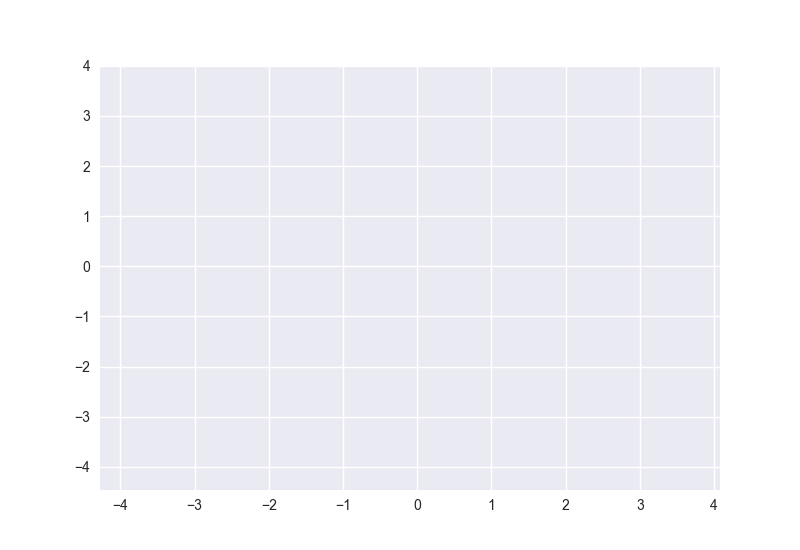

In [76]:
i = 0

colors = ['r','b','g','k', 'y', 'c', 'm', 'w']
def plot_next(click):
    global pca_matrix, i, ax
    if 0 <= i < n_patients:
        ax.scatter(pca_matrix[lengths[i]:lengths[i+1], 0], pca_matrix[lengths[i]:lengths[i+1], 1], color=colors[i], s=5, alpha=0.5)
        print('Plotted patient with index {}'.format(i))
    if i < n_patients:
        i += 1

def plot_prev(click):
    global pca_matrix, i, ax
    i -= 2
    plot_next(click)
    
def clear_plot(click):
    global ax, pca_matrix
    ax.clear()
    ax.set_ylim(pca_matrix[1].min(), pca_matrix[1].max())
    ax.set_xlim(pca_matrix[0].min(), pca_matrix[0].max())

def reset_count(click):
    global i
    i = 0
    
plt.figure()
ax = plt.subplot(111)
plt.ylim(pca_matrix[1].min(), pca_matrix[1].max())
plt.xlim(pca_matrix[0].min(), pca_matrix[0].max())

# Create buttons
plot_button = widgets.Button(description='Plot next patient')
clear_button = widgets.Button(description='Clear plot')
prev_button = widgets.Button(description='Plot previous patient')

# Connect buttons
plot_button.on_click(plot_next)
clear_button.on_click(clear_plot)
prev_button.on_click(plot_prev)

display(plot_button, prev_button, clear_button)

# Kernel PCA

In [ ]:
from sklearn.decomposition import KernelPCA


kpca = KernelPCA(kernel='rbf').fit_transform(dm_center)

<IPython.core.display.Javascript object>


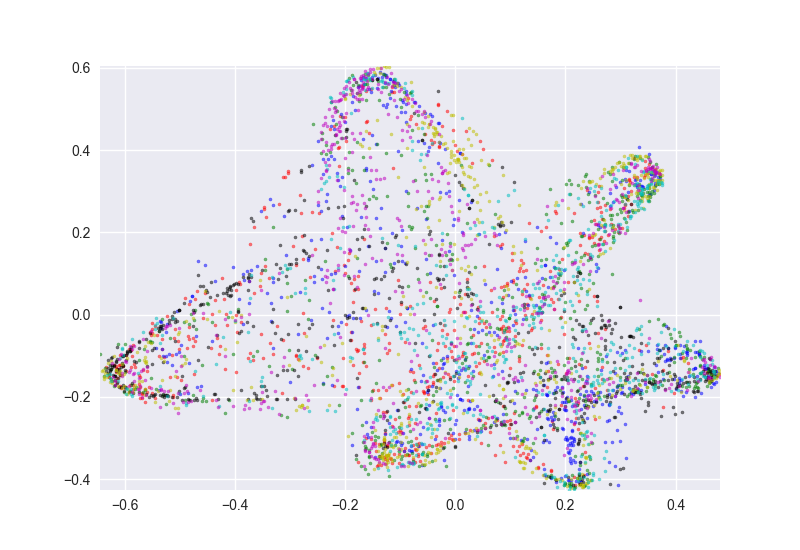

Plotted patient with index 0
Plotted patient with index 1
Plotted patient with index 2
Plotted patient with index 3
Plotted patient with index 4
Plotted patient with index 5
Plotted patient with index 6


In [78]:
i = 0

colors = ['r','b','g','k', 'y', 'c', 'm', 'w']
def plot_next(click):
    global pca_matrix, i, ax
    if 0 <= i < n_patients:
        ax.scatter(kpca[lengths[i]:lengths[i+1], 0], kpca[lengths[i]:lengths[i+1], 1], color=colors[i], s=5, alpha=0.5)
        print('Plotted patient with index {}'.format(i))
    if i < n_patients:
        i += 1

def plot_prev(click):
    global i, ax
    i -= 2
    plot_next(click)
    
def clear_plot(click):
    global ax, pca_matrix
    ax.clear()
    ax.set_ylim(kpca[:, 1].min(), kpca[:, 1].max())
    ax.set_xlim(kpca[:, 0].min(), kpca[:, 0].max())

def reset_count(click):
    global i
    i = 0
    
plt.figure()
ax = plt.subplot(111)
plt.ylim(kpca[:, 1].min(), kpca[:, 1].max())
plt.xlim(kpca[:, 0].min(), kpca[:, 0].max())

# Create buttons
plot_button = widgets.Button(description='Plot next patient')
clear_button = widgets.Button(description='Clear plot')
prev_button = widgets.Button(description='Plot previous patient')

# Connect buttons
plot_button.on_click(plot_next)
clear_button.on_click(clear_plot)
prev_button.on_click(plot_prev)

display(plot_button, prev_button, clear_button)

# Isomaps

In [11]:
from sklearn.manifold import Isomap

In [34]:
iso3 = Isomap(n_neighbors=4, n_components=2)
iso_cmp = iso3.fit_transform(dmr_center)

<IPython.core.display.Javascript object>


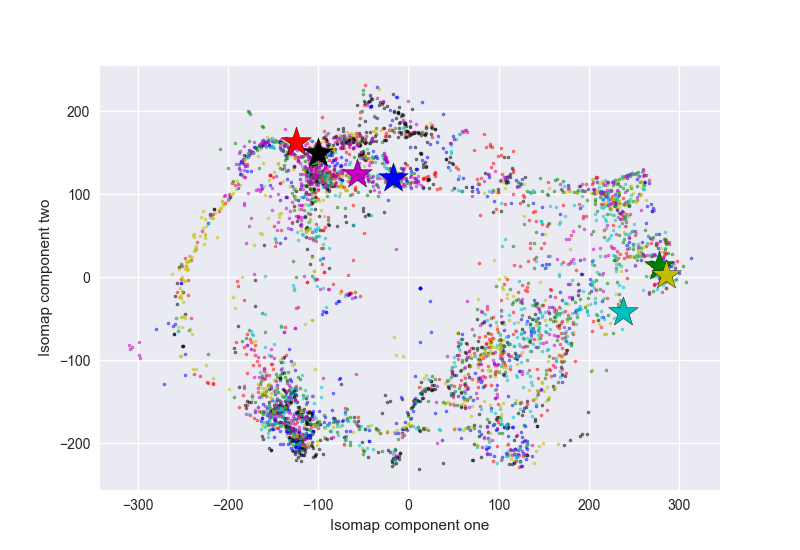

In [35]:
plt.figure()
sub = plt.subplot(111)
plt.xlabel('Isomap component one')
plt.ylabel('Isomap component two')

for i in range(len(patients)):
    sub.scatter(
        iso_cmp[lengths[i]:lengths[i+1], 0], 
        iso_cmp[lengths[i]:lengths[i+1], 1], 
        color=colors[i], 
        s=5, 
        alpha=0.5
    )
for i in range(len(patients)):
    sub.scatter(
        iso_cmp[lengths[-1]+i, 0],
        iso_cmp[lengths[-1]+i, 1], 
        color=colors[i],
        s=500,
        alpha=1,
        marker='*', 
        edgecolors='k'
    )

# Perform clustering on all data to see if patients cluster together

In [79]:
from sklearn.cluster import KMeans, SpectralClustering

n_clusters = 10

In [80]:
km_clusters = KMeans(n_clusters=n_clusters).fit_predict(dm)

In [55]:
sp = SpectralClustering(
    n_clusters = n_clusters,
    affinity = 'nearest_neighbors',
    n_neighbors = 15
)

sp_clusters = sp.fit_predict(dm)

<IPython.core.display.Javascript object>


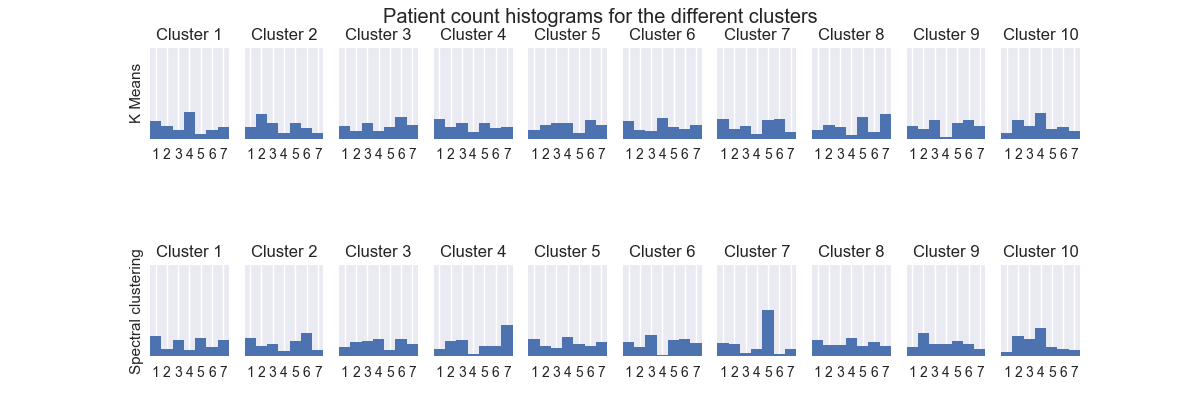

In [63]:
km_clusters_nos = [patient_nos[km_clusters == i] for i in range(n_clusters)]
sp_clusters_nos = [patient_nos[sp_clusters == i] for i in range(n_clusters)]

fig = plt.figure(figsize=(n_clusters + 2, 4))
fig.suptitle('Patient count histograms for the different clusters')
labels = ['K Means', 'Spectral clustering']
for i, cluster in enumerate([km_clusters_nos, sp_clusters_nos]):
    plt.subplot(3, n_clusters, i*2*n_clusters + 1)
    plt.ylabel(labels[i])
    for j, patient in enumerate(cluster):
        plt.subplot(3, n_clusters, j+1 + 2*n_clusters*i)
        plt.hist(patient, bins=np.arange(0, 8, 1), normed=True)
        plt.yticks([])
        plt.xticks(np.arange(n_clusters)+0.5, np.arange(n_clusters)+1)
        plt.xlim([0, n_patients])
        plt.ylim([0, 1])
        plt.title('Cluster {}'.format(j+1))
        